In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/speech-understanding-457206-a2485146b69c.json"

## Noise Level Analysis

In [8]:
set1_clean_path = '/content/drive/MyDrive/set 1 - Clean and noisy/clean'
set1_noisy_path = '/content/drive/MyDrive/set 1 - Clean and noisy/noisy'
set2_noisy_path = '/content/drive/MyDrive/set 2 - only noisy'

In [17]:
def calculate_snr(clean_audio, noisy_audio):
    min_len = min(len(clean_audio), len(noisy_audio))
    clean_audio = clean_audio[:min_len]
    noisy_audio = noisy_audio[:min_len]

    noise = noisy_audio - clean_audio

    #  SNR
    signal_power = np.sum(clean_audio**2)
    noise_power = np.sum(noise**2)

    if noise_power == 0:  # Avoid division by zero
        return float('inf')

    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [19]:
def analyze_noise_spectrum(clean_audio, noisy_audio, sr=16000):
    min_len = min(len(clean_audio), len(noisy_audio))
    clean_audio = clean_audio[:min_len]
    noisy_audio = noisy_audio[:min_len]

    noise = noisy_audio - clean_audio

    # Calculate spectrum
    noise_spectrum = np.abs(librosa.stft(noise))
    noise_db = librosa.amplitude_to_db(noise_spectrum, ref=np.max)

    return noise_db

In [14]:
clean_files = [f for f in os.listdir(set1_clean_path) if f.endswith('.wav')]
noisy_files = [f for f in os.listdir(set1_noisy_path) if f.endswith('.wav')]
clean_indices = [f.split('_')[-1].replace('.wav', '') for f in clean_files]
noisy_indices = [f.split('_')[-1].replace('.wav', '') for f in noisy_files]

In [15]:
clean_files

['Datasets_clean_testset_wav_p232_001.wav',
 'Datasets_clean_testset_wav_p232_002.wav',
 'Datasets_clean_testset_wav_p232_003.wav',
 'Datasets_clean_testset_wav_p232_005.wav',
 'Datasets_clean_testset_wav_p232_006.wav',
 'Datasets_clean_testset_wav_p232_007.wav',
 'Datasets_clean_testset_wav_p232_009.wav',
 'Datasets_clean_testset_wav_p232_010.wav']

In [97]:
import librosa
import numpy as np
import os
from librosa.core import resample

def resample_audio(audio, original_sr, target_sr=16000):
    if original_sr != target_sr:
        audio = resample(audio, orig_sr=original_sr, target_sr=target_sr)
    return audio


noise_analysis= []

for i, clean_file in enumerate(clean_files):
    clean_index= clean_indices[i]
    matching_noisy_files= [f for j, f in enumerate(noisy_files) if noisy_indices[j] == clean_index]

    if matching_noisy_files:
        noisy_file= matching_noisy_files[0]

        clean_audio, sr_clean= librosa.load(os.path.join(set1_clean_path, clean_file), sr=None)
        noisy_audio, sr_noisy= librosa.load(os.path.join(set1_noisy_path, noisy_file), sr=None)

        # 16000 will be needed later for comparison for PESQs
        clean_audio = resample_audio(clean_audio, sr_clean, target_sr=16000)
        noisy_audio = resample_audio(noisy_audio, sr_noisy, target_sr=16000)


        snr = calculate_snr(clean_audio, noisy_audio)

        #noise spectrum
        noise_db = analyze_noise_spectrum(clean_audio, noisy_audio, sr=16000)
        avg_noise_by_freq = np.mean(noise_db, axis=1)
        peak_freq_bin = np.argmax(avg_noise_by_freq)

        noise_analysis.append({
            'clean_file': clean_file,
            'noisy_file': noisy_file,
            'snr': snr,
            'peak_freq_bin': peak_freq_bin,
            'avg_noise_level': np.mean(noise_db)
        })

        print(f"Analyzed pair: {clean_file} and {noisy_file}, SNR: {snr:.2f} dB")


Analyzed pair: Datasets_clean_testset_wav_p232_001.wav and Datasets_noisy_testset_wav_p232_001.wav, SNR: 15.47 dB
Analyzed pair: Datasets_clean_testset_wav_p232_002.wav and Datasets_noisy_testset_wav_p232_002.wav, SNR: 11.31 dB
Analyzed pair: Datasets_clean_testset_wav_p232_003.wav and Datasets_noisy_testset_wav_p232_003.wav, SNR: 6.71 dB
Analyzed pair: Datasets_clean_testset_wav_p232_005.wav and Datasets_noisy_testset_wav_p232_005.wav, SNR: 1.85 dB
Analyzed pair: Datasets_clean_testset_wav_p232_006.wav and Datasets_noisy_testset_wav_p232_006.wav, SNR: 16.86 dB
Analyzed pair: Datasets_clean_testset_wav_p232_007.wav and Datasets_noisy_testset_wav_p232_007.wav, SNR: 11.81 dB
Analyzed pair: Datasets_clean_testset_wav_p232_009.wav and Datasets_noisy_testset_wav_p232_009.wav, SNR: 6.78 dB
Analyzed pair: Datasets_clean_testset_wav_p232_010.wav and Datasets_noisy_testset_wav_p232_010.wav, SNR: 0.91 dB


In [98]:
noise_df = pd.DataFrame(noise_analysis)

In [99]:
noise_df

,clean_file,noisy_file,snr,peak_freq_bin,avg_noise_level
0,Datasets_clean_testset_wav_p232_001.wav,Datasets_noisy_testset_wav_p232_001.wav,15.473873,2,-69.060234
1,Datasets_clean_testset_wav_p232_002.wav,Datasets_noisy_testset_wav_p232_002.wav,11.311187,2,-69.236763
2,Datasets_clean_testset_wav_p232_003.wav,Datasets_noisy_testset_wav_p232_003.wav,6.714846,2,-70.889809
3,Datasets_clean_testset_wav_p232_005.wav,Datasets_noisy_testset_wav_p232_005.wav,1.852716,3,-60.026096
4,Datasets_clean_testset_wav_p232_006.wav,Datasets_noisy_testset_wav_p232_006.wav,16.855917,1,-56.351280
5,Datasets_clean_testset_wav_p232_007.wav,Datasets_noisy_testset_wav_p232_007.wav,11.813997,1,-50.377338
6,Datasets_clean_testset_wav_p232_009.wav,Datasets_noisy_testset_wav_p232_009.wav,6.784239,2,-63.374470
7,Datasets_clean_testset_wav_p232_010.wav,Datasets_noisy_testset_wav_p232_010.wav,0.906888,1,-46.984787


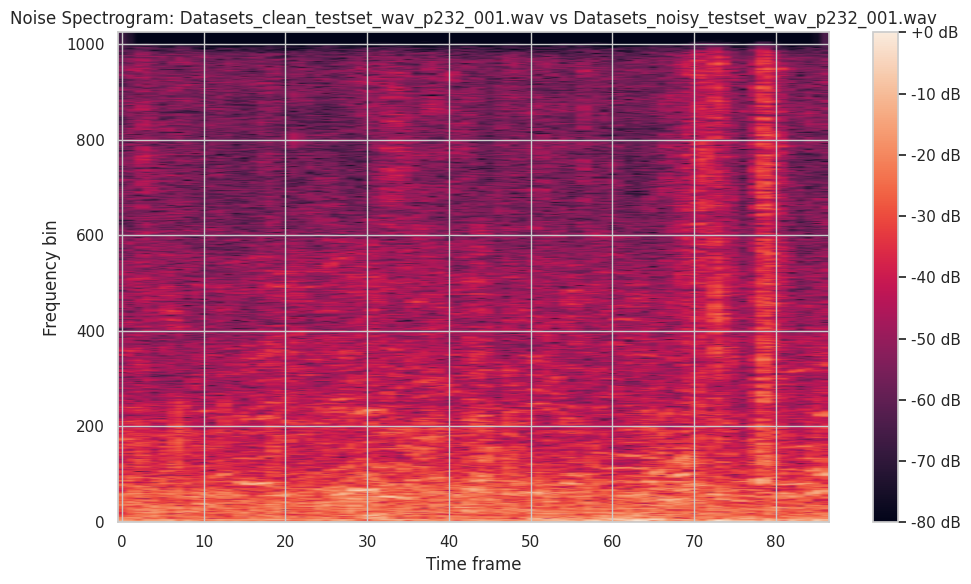

In [100]:
# Visualize noise spectrum for first file pair
if noise_analysis:
    plt.figure(figsize=(10, 6))
    plt.imshow(noise_db, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Noise Spectrogram: {noise_analysis[0]["clean_file"]} vs {noise_analysis[0]["noisy_file"]}')
    plt.ylabel('Frequency bin')
    plt.xlabel('Time frame')
    plt.tight_layout()
    plt.show()

<ipython-input-101-6632eeb03a8b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="noisy_file", y="snr", data=noise_df, palette="viridis")


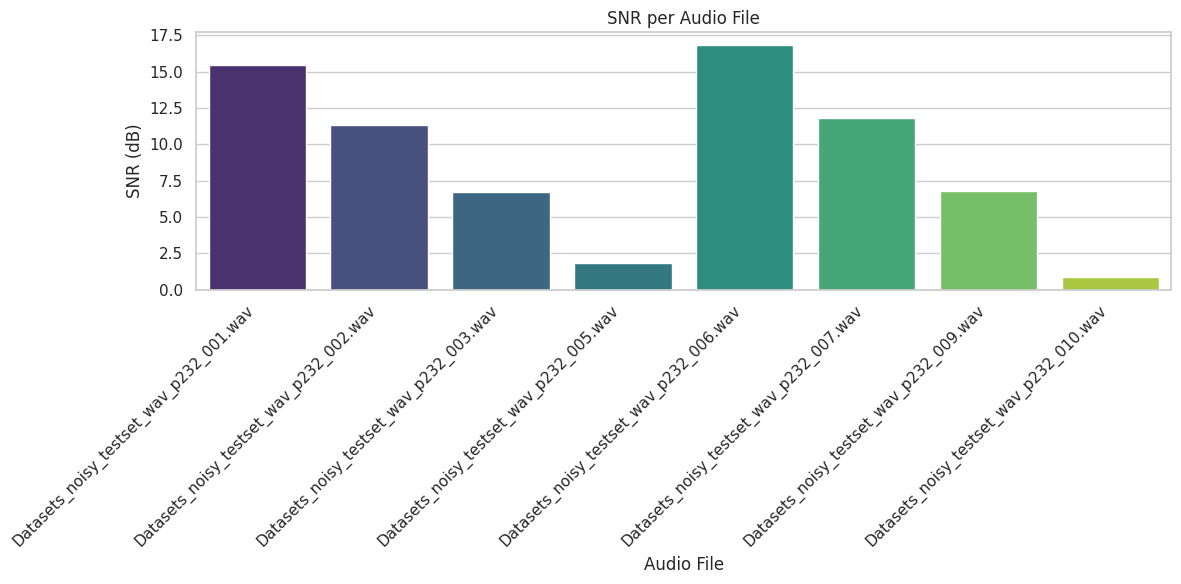

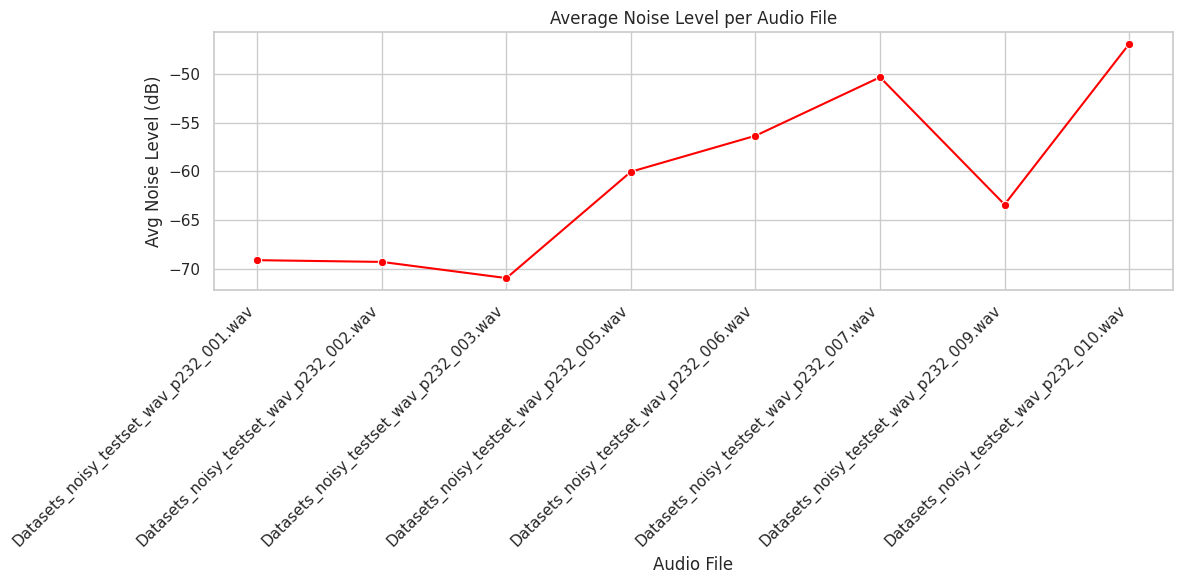

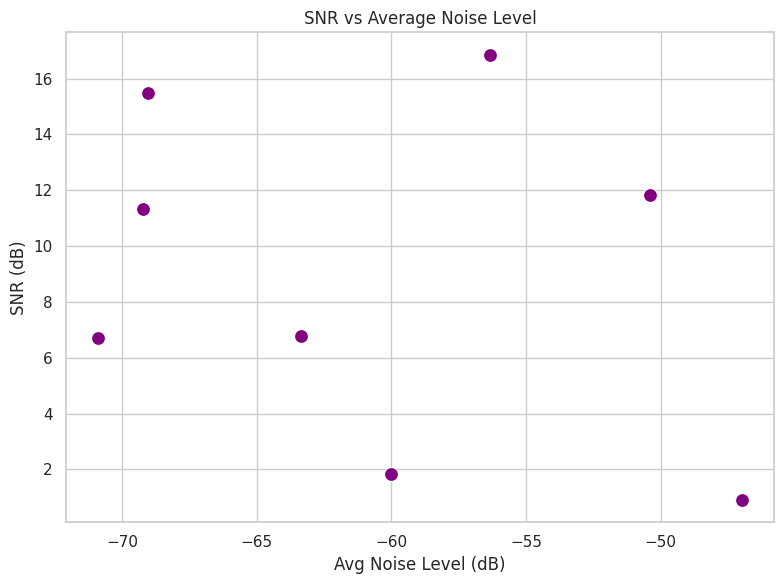

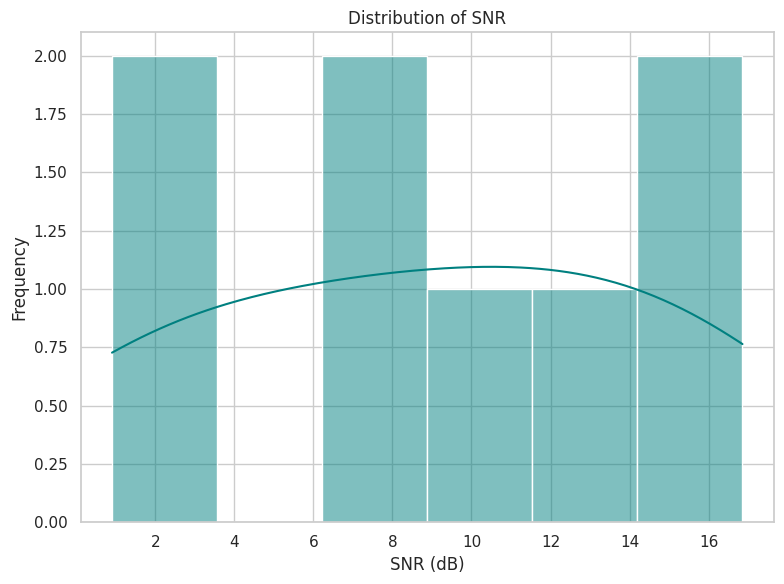

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# SNR
plt.figure(figsize=(12, 6))
sns.barplot(x="noisy_file", y="snr", data=noise_df, palette="viridis")
plt.title("SNR per Audio File")
plt.xlabel("Audio File")
plt.ylabel("SNR (dB)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Average Noise Level
plt.figure(figsize=(12, 6))
sns.lineplot(x="noisy_file", y="avg_noise_level", data=noise_df, marker="o", color="red")
plt.title("Average Noise Level per Audio File")
plt.xlabel("Audio File")
plt.ylabel("Avg Noise Level (dB)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#  Scatter Plot: SNR vs. Avg Noise Level
plt.figure(figsize=(8, 6))
sns.scatterplot(x="avg_noise_level", y="snr", data=noise_df, s=100, color="purple")
plt.title("SNR vs Average Noise Level")
plt.xlabel("Avg Noise Level (dB)")
plt.ylabel("SNR (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
sns.histplot(noise_df["snr"], bins=6, kde=True, color="teal")
plt.title("Distribution of SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## Denoising Algorithm Design

In [103]:
from librosa.core import resample as librosa_resample

def spectral_subtraction(noisy_audio, sr, n_fft=2048, hop_length=512, noise_reduction_factor=1.0, target_sr=16000):
    if sr != target_sr:
        noisy_audio = librosa_resample(y=noisy_audio, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    # spectrogram
    stft = librosa.stft(noisy_audio, n_fft=n_fft, hop_length=hop_length)
    magnitude, phase = librosa.magphase(stft)
    # noise from the first 0.5 seconds (assumed to be noise-only)
    noise_length = min(int(0.5 * sr), len(noisy_audio))
    noise_stft = librosa.stft(noisy_audio[:noise_length], n_fft=n_fft, hop_length=hop_length)
    noise_magnitude = np.abs(noise_stft)
    noise_profile = np.mean(noise_magnitude, axis=1).reshape(-1, 1)

    # spectral subtraction
    magnitude_subtracted = magnitude - noise_reduction_factor * noise_profile
    magnitude_subtracted = np.maximum(magnitude_subtracted, 0.01 * magnitude)  # Spectral floor

    enhanced_stft = magnitude_subtracted * phase
    enhanced_audio = librosa.istft(enhanced_stft, hop_length=hop_length)
    return enhanced_audio


In [105]:
def wiener_filter(noisy_audio, sr, n_fft=2048, hop_length=512, target_sr=16000):
    if sr!= target_sr:
        noisy_audio = librosa_resample(y=noisy_audio, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    stft= librosa.stft(noisy_audio, n_fft=n_fft, hop_length=hop_length)
    magnitude, phase = librosa.magphase(stft)

    # noise from first 0.5 seconds
    noise_length = min(int(0.5 * sr), len(noisy_audio))
    noise_stft = librosa.stft(noisy_audio[:noise_length], n_fft=n_fft, hop_length=hop_length)
    noise_magnitude = np.abs(noise_stft)
    noise_power = np.mean(noise_magnitude**2, axis=1).reshape(-1, 1)
    signal_power = magnitude**2
    wiener_gain = np.maximum(1 - noise_power / (signal_power + 1e-10), 0.1)
    enhanced_magnitude = magnitude * wiener_gain
    enhanced_stft= enhanced_magnitude * phase
    enhanced_audio= librosa.istft(enhanced_stft, hop_length=hop_length)
    return enhanced_audio


In [106]:
import librosa
import soundfile as sf

def denoise_audio(noisy_file, method='wiener', output_file=None, target_sr=16000):
    noisy_audio, sr = librosa.load(noisy_file, sr=None)
    if sr != target_sr:
        noisy_audio = librosa.resample(y=noisy_audio, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    if method== 'spectral_subtraction':
        enhanced_audio = spectral_subtraction(noisy_audio, sr)
    elif method== 'wiener':
        enhanced_audio = wiener_filter(noisy_audio, sr)
    else:
        raise ValueError(f"Unknown denoising method: {method}")

    if output_file:
        sf.write(output_file, enhanced_audio, sr)

    return enhanced_audio, sr





In [107]:
def process_directory(input_dir, output_dir, method='wiener'):
    os.makedirs(output_dir, exist_ok=True)

    for file in os.listdir(input_dir):
        if file.endswith('.wav'):
            input_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_dir, f"enhanced_{file}")

            print(f"Processing {file}...")
            enhanced_audio, sr = denoise_audio(input_path, method=method, output_file=output_path)
            print(f"Saved enhanced audio to {output_path}")

In [108]:
output_dir = '/content/drive/MyDrive/enhanced_audio'
os.makedirs(output_dir, exist_ok=True)

# You can also try different methods for comparison
methods = ['spectral_subtraction', 'wiener']
for method in methods:
    output_method_dir = os.path.join(output_dir, method)
    process_directory(set1_noisy_path, output_method_dir, method=method)

Processing Datasets_noisy_testset_wav_p232_001.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio/spectral_subtraction/enhanced_Datasets_noisy_testset_wav_p232_001.wav
Processing Datasets_noisy_testset_wav_p232_002.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio/spectral_subtraction/enhanced_Datasets_noisy_testset_wav_p232_002.wav
Processing Datasets_noisy_testset_wav_p232_003.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio/spectral_subtraction/enhanced_Datasets_noisy_testset_wav_p232_003.wav
Processing Datasets_noisy_testset_wav_p232_005.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio/spectral_subtraction/enhanced_Datasets_noisy_testset_wav_p232_005.wav
Processing Datasets_noisy_testset_wav_p232_006.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio/spectral_subtraction/enhanced_Datasets_noisy_testset_wav_p232_006.wav
Processing Datasets_noisy_testset_wav_p232_007.wav...
Saved enhanced a

## Transcription

In [38]:
!pip install google-cloud-speech

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.1/334.1 kB 5.6 MB/s eta 0:00:00


In [121]:
from google.cloud import speech
import os
import librosa
import soundfile as sf
import tempfile

def transcribe_wav_file(input_path):
    client = speech.SpeechClient()
    audio_data, sr = librosa.load(input_path, sr=None)
    if sr != 16000:
        audio_data = librosa.resample(audio_data, orig_sr=sr, target_sr=16000)
        sr = 16000
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
        temp_path = tmp.name
        sf.write(temp_path, audio_data, sr)
    with open(temp_path, "rb") as audio_file:
        content = audio_file.read()

    os.remove(temp_path)

    # transcription
    audio = speech.RecognitionAudio(content=content)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=16000,
        language_code="en-US",
        enable_automatic_punctuation=True,
    )

    print(f"Transcribing: {os.path.basename(input_path)}")
    response = client.recognize(config=config, audio=audio)
    transcript = ""
    for result in response.results:
        print(result.alternatives[0].transcript.strip())
        transcript += result.alternatives[0].transcript.strip() + " "
    return transcript.strip()



In [59]:
transcribe_wav_file('/content/drive/MyDrive/enhanced_audio/spectral_subtraction/enhanced_Datasets_noisy_testset_wav_p232_001.wav')

Transcribing: enhanced_Datasets_noisy_testset_wav_p232_001.wav
Please call Stella.


'Please call Stella.'

In [122]:
def process_folder(folder_path, output_txt):
    with open(output_txt, "w", encoding="utf-8") as out_f:
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path) and file.endswith(".wav"):
                try:
                    text = transcribe_wav_file(file_path)
                    out_f.write(text + "\n")  # One line per file
                except Exception as e:
                    print(f"Error transcribing {file}: {e}")

In [123]:
ss_path='/content/drive/MyDrive/enhanced_audio/spectral_subtraction'


In [124]:
process_folder(ss_path, "ss_transcriptions.txt")

Transcribing: enhanced_Datasets_noisy_testset_wav_p232_001.wav
Please call Stella.
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_002.wav
Ask her to bring these things with her from the store.
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_003.wav
6 spoons of fresh snow peas, 5, thick slabs of blue cheese and maybe a snack for her brother Bob.
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_005.wav
She can scoop these things into 3, red bags and we will go meet her Wednesday at the train station.
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_006.wav
when the sunlight strikes raindrops in the air, they act as a prism and form a rainbow
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_007.wav
The rainbow is a division of white light into many beautiful colors.
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_009.wav
There is according to Legend a boiling pot of gold at 1 end.
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_010.wav
Keep a

In [142]:
w_path='/content/drive/MyDrive/enhanced_audio/wiener'

In [143]:
process_folder(w_path, "w_transcriptions.txt")

Transcribing: enhanced_Datasets_noisy_testset_wav_p232_001.wav
Please call Stella.
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_002.wav
Ask her to bring these things with her from the store.
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_003.wav
6 spoons of fresh snow peas, 5, thick slabs of blue cheese and maybe a snack for her brother Bob.
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_005.wav
She can scoop these things into 3, red bags and we will go meet her Wednesday at the train station.
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_006.wav
when the sunlight strikes raindrops in the air, they act as a prism and form a rainbow
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_007.wav
The rainbow is a division of white light into many beautiful colors.
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_009.wav
There is according to Legend a boiling pot of gold at 1 end.
Transcribing: enhanced_Datasets_noisy_testset_wav_p232_010.wav
Keep a

In [127]:
clean_path='/content/drive/MyDrive/set 1 - Clean and noisy/clean'

In [128]:
process_folder(clean_path, "clean_transcriptions.txt")

Transcribing: Datasets_clean_testset_wav_p232_001.wav
Please call Stella.
Transcribing: Datasets_clean_testset_wav_p232_002.wav
Ask her to bring these things with her from the store.
Transcribing: Datasets_clean_testset_wav_p232_003.wav
6 spoons of fresh snow peas, 5 thick slabs of blue cheese and maybe a snack with her brother Bob.
Transcribing: Datasets_clean_testset_wav_p232_005.wav
She can scoop these things into 3, red bags and we will go meet her Wednesday at the train station.
Transcribing: Datasets_clean_testset_wav_p232_006.wav
when the sunlight strikes raindrops in the air, they act as a prism and form a rainbow
Transcribing: Datasets_clean_testset_wav_p232_007.wav
The rainbow is a division of white light into many beautiful colors.
Transcribing: Datasets_clean_testset_wav_p232_009.wav
There is according to Legend a boiling pot of gold at 1 end.
Transcribing: Datasets_clean_testset_wav_p232_010.wav
People look but no 1 ever finds it.


## Performance Evaluation

In [88]:
pip install pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=274954 sha256=244f2912bbe03b0da447b354e49c15cde8cf46a669487a30ef572f3a8a07b76d
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


enhanced_Datasets_noisy_testset_wav_p232_001.wav - SNR: 22.34 dB, PESQ: 2.77
enhanced_Datasets_noisy_testset_wav_p232_002.wav - SNR: 17.86 dB, PESQ: 3.11
enhanced_Datasets_noisy_testset_wav_p232_003.wav - SNR: 18.77 dB, PESQ: 3.13
enhanced_Datasets_noisy_testset_wav_p232_005.wav - SNR: 6.77 dB, PESQ: 1.51
enhanced_Datasets_noisy_testset_wav_p232_006.wav - SNR: 19.01 dB, PESQ: 2.53
enhanced_Datasets_noisy_testset_wav_p232_007.wav - SNR: 14.31 dB, PESQ: 1.95
enhanced_Datasets_noisy_testset_wav_p232_009.wav - SNR: 12.24 dB, PESQ: 2.01
enhanced_Datasets_noisy_testset_wav_p232_010.wav - SNR: 4.60 dB, PESQ: 1.26


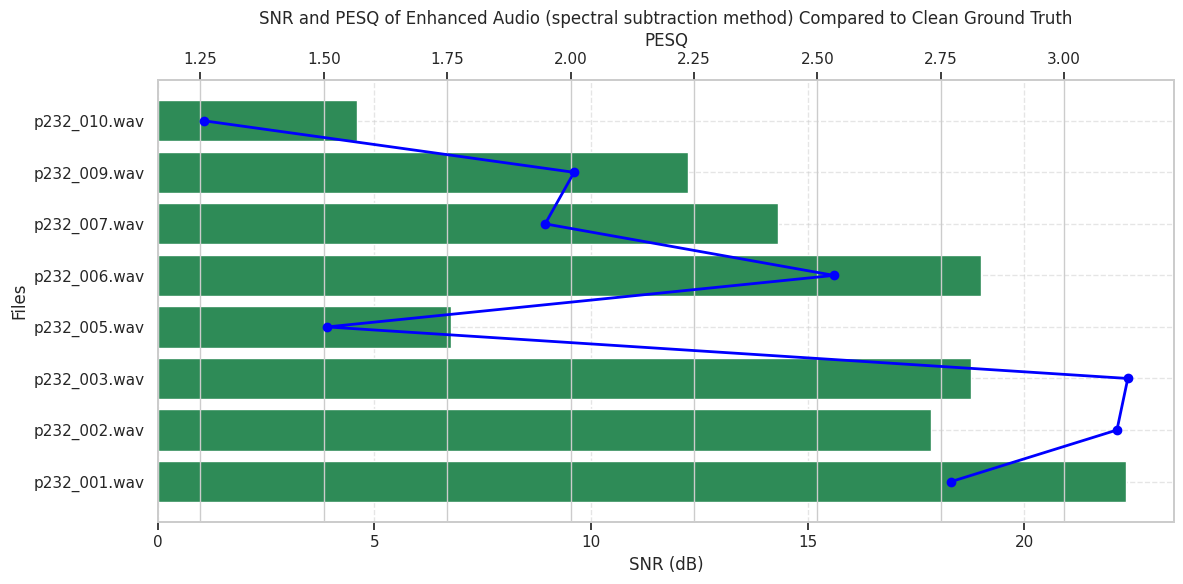

In [131]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
from pesq import pesq


def calculate_pesq(clean_audio, enh_audio, sr):
    return pesq(sr, clean_audio, enh_audio)


def resample_audio(audio, sr, target_sr=16000):
    if sr != target_sr:
        audio = librosa.resample(audio.astype(np.float32), orig_sr=sr, target_sr=target_sr)
    return audio

# enhanced and clean audio
enhanced_path = "/content/drive/MyDrive/enhanced_audio/spectral_subtraction"
clean_path = "/content/drive/MyDrive/set 1 - Clean and noisy/clean"

clean_suffix_map = {}
for file in os.listdir(clean_path):
    if file.endswith(".wav"):
        suffix = "_".join(file.split("_")[-2:])  # e.g., "p232_001.wav"
        clean_suffix_map[suffix] = os.path.join(clean_path, file)


snr_scores = []
pesq_scores = []
file_labels = []


for file in os.listdir(enhanced_path):
    if file.endswith(".wav"):
        suffix = "_".join(file.split("_")[-2:])
        clean_file = clean_suffix_map.get(suffix)

        if clean_file:
            enh_file = os.path.join(enhanced_path, file)

            # raw audio
            sr_clean, clean_audio = wavfile.read(clean_file)
            sr_enh, enh_audio = wavfile.read(enh_file)

            # Resample both to 16000 Hz
            clean_audio_resampled = resample_audio(clean_audio, sr_clean, target_sr=16000)
            enh_audio_resampled = resample_audio(enh_audio, sr_enh, target_sr=16000)
            min_len = min(len(clean_audio_resampled), len(enh_audio_resampled))
            clean_audio_resampled = clean_audio_resampled[:min_len]
            enh_audio_resampled = enh_audio_resampled[:min_len]

            # Calculate SNR and PESQ
            snr = calculate_snr(clean_audio_resampled, enh_audio_resampled)
            pesq_score = calculate_pesq(clean_audio_resampled, enh_audio_resampled, 16000)

            snr_scores.append(snr)
            pesq_scores.append(pesq_score)
            file_labels.append(suffix)

            print(f"{file} - SNR: {snr:.2f} dB, PESQ: {pesq_score:.2f}")
        else:
            print(f"No clean match for {file}")

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.barh(file_labels, snr_scores, color='seagreen', label='SNR')
ax1.set_xlabel('SNR (dB)')
ax1.set_ylabel('Files')
ax1.set_title('SNR and PESQ of Enhanced Audio (spectral subtraction method) Compared to Clean Ground Truth')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twiny()
ax2.plot(pesq_scores, file_labels, color='blue', marker='o', label='PESQ', linestyle='-', linewidth=2)
ax2.set_xlabel('PESQ')

plt.tight_layout()
plt.show()


enhanced_Datasets_noisy_testset_wav_p232_001.wav - SNR: 20.94 dB, PESQ: 2.76
enhanced_Datasets_noisy_testset_wav_p232_002.wav - SNR: 16.16 dB, PESQ: 3.04
enhanced_Datasets_noisy_testset_wav_p232_003.wav - SNR: 16.97 dB, PESQ: 3.05
enhanced_Datasets_noisy_testset_wav_p232_005.wav - SNR: 5.23 dB, PESQ: 1.47
enhanced_Datasets_noisy_testset_wav_p232_006.wav - SNR: 18.84 dB, PESQ: 2.50
enhanced_Datasets_noisy_testset_wav_p232_007.wav - SNR: 14.55 dB, PESQ: 1.95
enhanced_Datasets_noisy_testset_wav_p232_009.wav - SNR: 11.07 dB, PESQ: 1.93
enhanced_Datasets_noisy_testset_wav_p232_010.wav - SNR: 3.30 dB, PESQ: 1.25


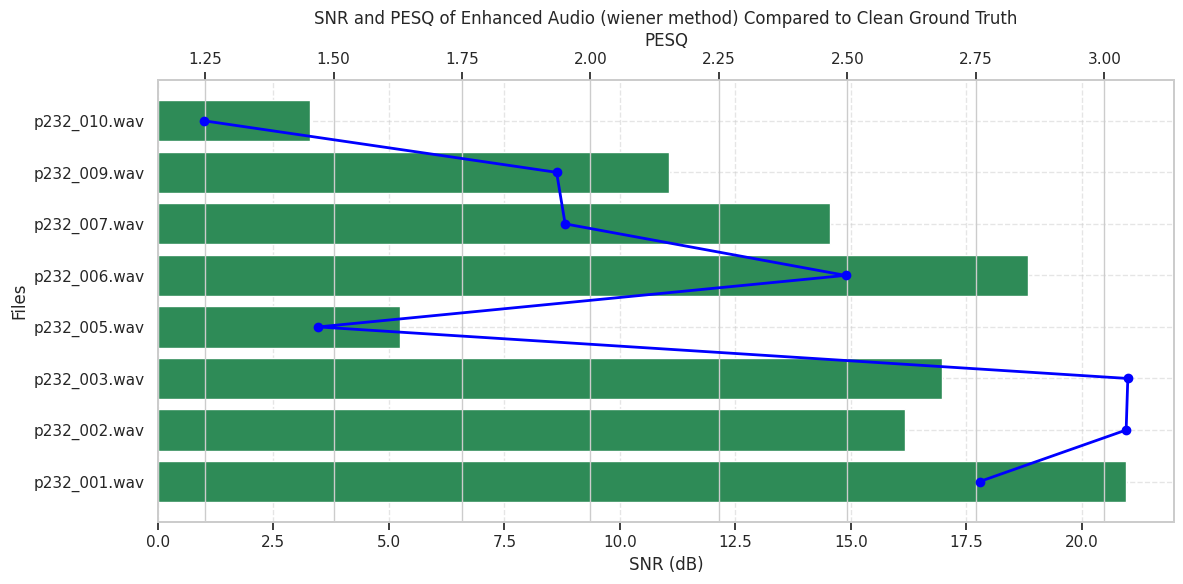

In [132]:
enhanced_path = "/content/drive/MyDrive/enhanced_audio/wiener"
clean_path = "/content/drive/MyDrive/set 1 - Clean and noisy/clean"

# Create dict of clean files with suffixes
clean_suffix_map = {}
for file in os.listdir(clean_path):
    if file.endswith(".wav"):
        suffix = "_".join(file.split("_")[-2:])  # e.g., "p232_001.wav"
        clean_suffix_map[suffix] = os.path.join(clean_path, file)

# Initialize scores
snr_scores = []
pesq_scores = []
file_labels = []

# Loop through enhanced files and compute metrics
for file in os.listdir(enhanced_path):
    if file.endswith(".wav"):
        suffix = "_".join(file.split("_")[-2:])
        clean_file = clean_suffix_map.get(suffix)

        if clean_file:
            enh_file = os.path.join(enhanced_path, file)

            # Read raw audio
            sr_clean, clean_audio = wavfile.read(clean_file)
            sr_enh, enh_audio = wavfile.read(enh_file)

            # Resample both to 16000 Hz
            clean_audio_resampled = resample_audio(clean_audio, sr_clean, target_sr=16000)
            enh_audio_resampled = resample_audio(enh_audio, sr_enh, target_sr=16000)

            # Trim to match length
            min_len = min(len(clean_audio_resampled), len(enh_audio_resampled))
            clean_audio_resampled = clean_audio_resampled[:min_len]
            enh_audio_resampled = enh_audio_resampled[:min_len]

            # Calculate SNR and PESQ
            snr = calculate_snr(clean_audio_resampled, enh_audio_resampled)
            pesq_score = calculate_pesq(clean_audio_resampled, enh_audio_resampled, 16000)

            snr_scores.append(snr)
            pesq_scores.append(pesq_score)
            file_labels.append(suffix)

            print(f"{file} - SNR: {snr:.2f} dB, PESQ: {pesq_score:.2f}")
        else:
            print(f"No clean match for {file}")

# Plot results
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.barh(file_labels, snr_scores, color='seagreen', label='SNR')
ax1.set_xlabel('SNR (dB)')
ax1.set_ylabel('Files')
ax1.set_title('SNR and PESQ of Enhanced Audio (wiener method) Compared to Clean Ground Truth')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twiny()
ax2.plot(pesq_scores, file_labels, color='blue', marker='o', label='PESQ', linestyle='-', linewidth=2)
ax2.set_xlabel('PESQ')

plt.tight_layout()
plt.show()


In [133]:
pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.1 MB/s eta 0:00:00


wer of sentence 1:  0.0
cer of sentence 1:  0.0
wer of sentence 2:  0.0
cer of sentence 2:  0.0
wer of sentence 3:  0.1
cer of sentence 3:  0.05154639175257732
wer of sentence 4:  0.0
cer of sentence 4:  0.0
wer of sentence 5:  0.0
cer of sentence 5:  0.0
wer of sentence 6:  0.0
cer of sentence 6:  0.0
wer of sentence 7:  0.0
cer of sentence 7:  0.0
wer of sentence 8:  0.5
cer of sentence 8:  0.17142857142857143
Average WER: 0.075
Average CER: 0.028


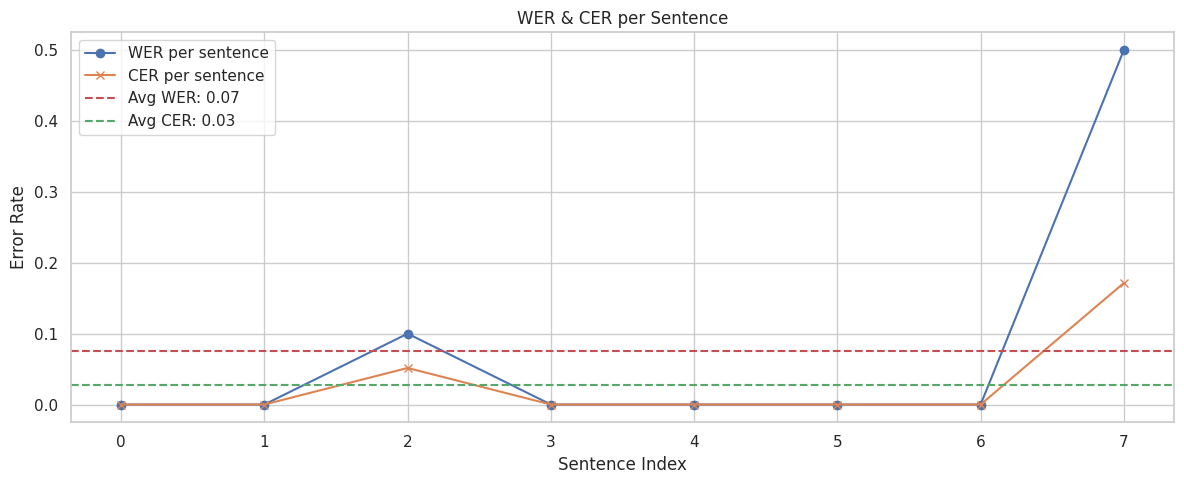

In [140]:
from jiwer import wer, cer
import matplotlib.pyplot as plt

with open("/content/clean_transcriptions.txt", "r", encoding='utf-8') as ref_file:
    reference_lines = [line.strip().lower() for line in ref_file if line.strip()]

with open("/content/ss_transcriptions.txt", "r", encoding='utf-8') as hyp_file:
    hypothesis_lines = [line.strip().lower() for line in hyp_file if line.strip()]


# Compute WER line by line
wer_scores= []
cer_scores= []
i=1
for ref, hyp in zip(reference_lines, hypothesis_lines):
    wer_score = wer(ref, hyp)
    cer_score = cer(ref, hyp)
    print(f"wer of sentence {i}: ", wer_score)
    print(f"cer of sentence {i}: ",cer_score)
    wer_scores.append(wer_score)
    cer_scores.append(cer_score)
    i+=1

# Average WER and CER
average_wer = sum(wer_scores) / len(wer_scores)
average_cer = sum(cer_scores) / len(cer_scores)
print(f"Average WER: {average_wer:.3f}")
print(f"Average CER: {average_cer:.3f}")

plt.figure(figsize=(12, 5))
plt.plot(wer_scores, label='WER per sentence', marker='o')
plt.plot(cer_scores, label='CER per sentence', marker='x')
plt.axhline(average_wer, color='r', linestyle='--', label=f'Avg WER: {average_wer:.2f}')
plt.axhline(average_cer, color='g', linestyle='--', label=f'Avg CER: {average_cer:.2f}')
plt.xlabel("Sentence Index")
plt.ylabel("Error Rate")
plt.title("WER & CER per Sentence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


wer of sentence 1:  0.0
cer of sentence 1:  0.0
wer of sentence 2:  0.0
cer of sentence 2:  0.0
wer of sentence 3:  0.1
cer of sentence 3:  0.05154639175257732
wer of sentence 4:  0.0
cer of sentence 4:  0.0
wer of sentence 5:  0.0
cer of sentence 5:  0.0
wer of sentence 6:  0.0
cer of sentence 6:  0.0
wer of sentence 7:  0.0
cer of sentence 7:  0.0
wer of sentence 8:  0.625
cer of sentence 8:  0.3142857142857143
Average WER: 0.091
Average CER: 0.046


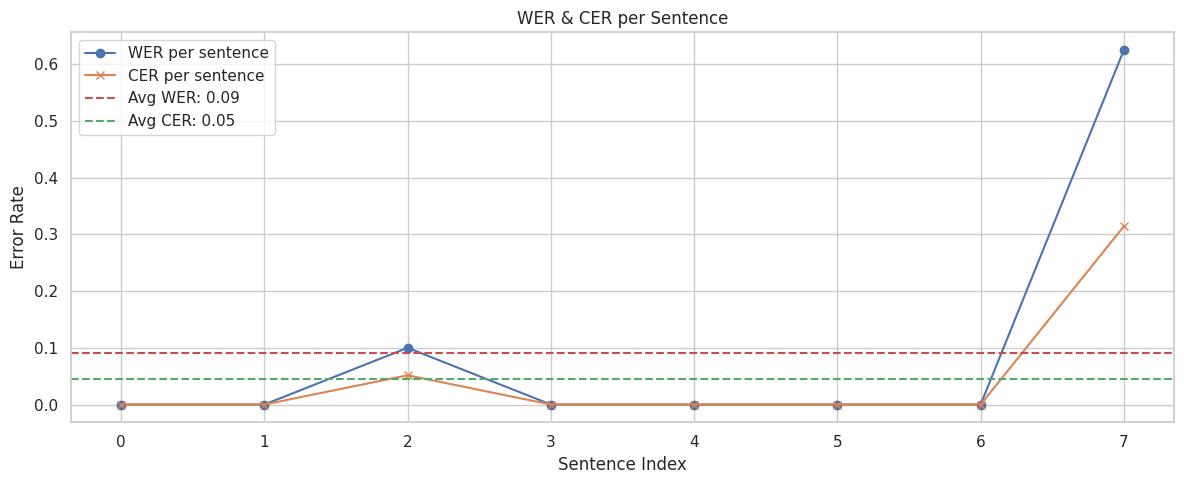

In [141]:
# Load reference and hypothesis transcripts
with open("/content/clean_transcriptions.txt", "r", encoding='utf-8') as ref_file:
    reference_lines = [line.strip().lower() for line in ref_file if line.strip()]

with open("/content/w_transcriptions.txt", "r", encoding='utf-8') as hyp_file:
    hypothesis_lines = [line.strip().lower() for line in hyp_file if line.strip()]

wer_scores = []
cer_scores = []
i=1
for ref, hyp in zip(reference_lines, hypothesis_lines):
    wer_score = wer(ref, hyp)
    cer_score = cer(ref, hyp)
    print(f"wer of sentence {i}: ", wer_score)
    print(f"cer of sentence {i}: ",cer_score)
    wer_scores.append(wer_score)
    cer_scores.append(cer_score)
    i+=1


average_wer = sum(wer_scores) / len(wer_scores)
average_cer = sum(cer_scores) / len(cer_scores)
print(f"Average WER: {average_wer:.3f}")
print(f"Average CER: {average_cer:.3f}")

plt.figure(figsize=(12, 5))
plt.plot(wer_scores, label='WER per sentence', marker='o')
plt.plot(cer_scores, label='CER per sentence', marker='x')
plt.axhline(average_wer, color='r', linestyle='--', label=f'Avg WER: {average_wer:.2f}')
plt.axhline(average_cer, color='g', linestyle='--', label=f'Avg CER: {average_cer:.2f}')
plt.xlabel("Sentence Index")
plt.ylabel("Error Rate")
plt.title("WER & CER per Sentence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Checking transcriptions of enhanced (only) noisy samples

In [144]:
process_folder('/content/drive/MyDrive/set 2 - only noisy', "only_noise.txt")

Transcribing: cafe.wav
A year earlier. GM Hughes had first quarter profit of 116.2 million or 77 cents a share.
Transcribing: ped.wav
Sources to say at least 2 bitters, had some doubts about City, Court's performance numbers.
Transcribing: street.wav
Base rates are The Benchmark for commercial lending equipment.
Transcribing: bus.wav
rates are expected to remain at those levels, remove a little higher this week at the treasury Department's, quarterly auctions,


In [145]:
output_dir = '/content/drive/MyDrive/enhanced_audio2'
os.makedirs(output_dir, exist_ok=True)
methods = ['spectral_subtraction', 'wiener']
for method in methods:
    output_method_dir = os.path.join(output_dir, method)
    process_directory(set2_noisy_path, output_method_dir, method=method)

Processing cafe.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio2/spectral_subtraction/enhanced_cafe.wav
Processing ped.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio2/spectral_subtraction/enhanced_ped.wav
Processing street.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio2/spectral_subtraction/enhanced_street.wav
Processing bus.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio2/spectral_subtraction/enhanced_bus.wav
Processing cafe.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio2/wiener/enhanced_cafe.wav
Processing ped.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio2/wiener/enhanced_ped.wav
Processing street.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio2/wiener/enhanced_street.wav
Processing bus.wav...
Saved enhanced audio to /content/drive/MyDrive/enhanced_audio2/wiener/enhanced_bus.wav


In [147]:
process_folder('/content/drive/MyDrive/enhanced_audio2/spectral_subtraction', "ss_transcription_noisy.txt")

Transcribing: enhanced_cafe.wav
A year earlier. GM Hughes had first quarter profit of 116.2 million or 77 cents a share.
Transcribing: enhanced_ped.wav
Sources say at least 2 bits and some doubts about Sydney course performance numbers.
Transcribing: enhanced_street.wav
These rates are The Benchmark for commercial lending.
Transcribing: enhanced_bus.wav
Rates are expected to remain at those levels or move a little higher this week at the treasury Department's, quarterly auctions.


In [148]:
process_folder('/content/drive/MyDrive/enhanced_audio2/wiener', "w_transcription_noisy.txt")

Transcribing: enhanced_cafe.wav
A year earlier. GM Hughes had first quarter profit of 116.2 million or 77 cents a share.
Transcribing: enhanced_ped.wav
Sources say at least 2 bits and some doubts about City course performance numbers.
Transcribing: enhanced_street.wav
Base rates are The Benchmark for commercial lending.
Transcribing: enhanced_bus.wav
Rates are expected to remain at those levels or move a little higher this week at the treasury Department's, quarterly auctions.


   filename  noisy_snr  enhanced_snr  snr_improvement
0  p232_001      15.47         22.34             6.87
1  p232_002      11.31         17.86             6.55
2  p232_003       6.71         18.77            12.06
3  p232_005       1.85          6.77             4.92
4  p232_006      16.86         19.01             2.15
5  p232_007      11.81         14.31             2.50
6  p232_009       6.78         12.24             5.46
7  p232_010       0.91          4.60             3.69


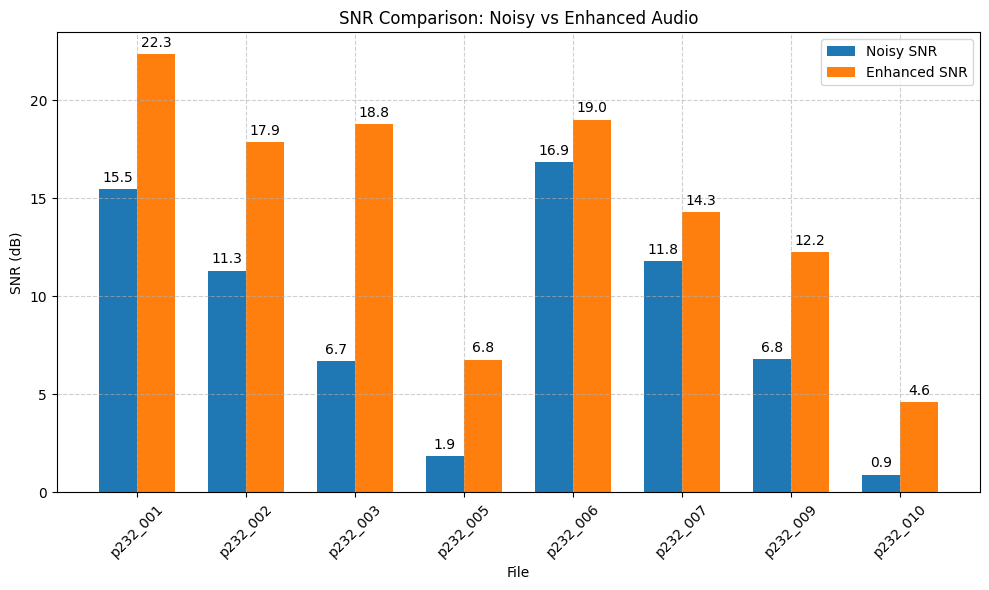


Average SNR Improvement: 5.52 dB


In [1]:

# Raw SNR values from noisy audio
noisy_data = {
    'filename': [
        'p232_001', 'p232_002', 'p232_003', 'p232_005',
        'p232_006', 'p232_007', 'p232_009', 'p232_010'
    ],
    'noisy_snr': [
        15.47, 11.31, 6.71, 1.85, 16.86, 11.81, 6.78, 0.91
    ]
}

# SNR values from enhanced (denoised) audio
enhanced_data = {
    'filename': [
        'p232_001', 'p232_002', 'p232_003', 'p232_005',
        'p232_006', 'p232_007', 'p232_009', 'p232_010'
    ],
    'enhanced_snr': [
        22.34, 17.86, 18.77, 6.77, 19.01, 14.31, 12.24, 4.60
    ]
}
df_noisy = pd.DataFrame(noisy_data)
df_enhanced = pd.DataFrame(enhanced_data)
df_combined = pd.merge(df_noisy, df_enhanced, on='filename')

df_combined['snr_improvement'] = df_combined['enhanced_snr'] - df_combined['noisy_snr']
print(df_combined)
x = np.arange(len(df_combined))  # label locations
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, df_combined['noisy_snr'], width, label='Noisy SNR')
bars2 = ax.bar(x + width/2, df_combined['enhanced_snr'], width, label='Enhanced SNR')

ax.set_xlabel('File')
ax.set_ylabel('SNR (dB)')
ax.set_title('SNR Comparison: Noisy vs Enhanced Audio')
ax.set_xticks(x)
ax.set_xticklabels(df_combined['filename'], rotation=45)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)


for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

avg_improvement = df_combined['snr_improvement'].mean()
print(f"\nAverage SNR Improvement: {avg_improvement:.2f} dB")


   filename  noisy_snr  enhanced_snr  snr_improvement
0  p232_001      15.47         20.94             5.47
1  p232_002      11.31         16.16             4.85
2  p232_003       6.71         16.97            10.26
3  p232_005       1.85          5.23             3.38
4  p232_006      16.86         18.84             1.98
5  p232_007      11.81         14.55             2.74
6  p232_009       6.78         11.07             4.29
7  p232_010       0.91          3.30             2.39


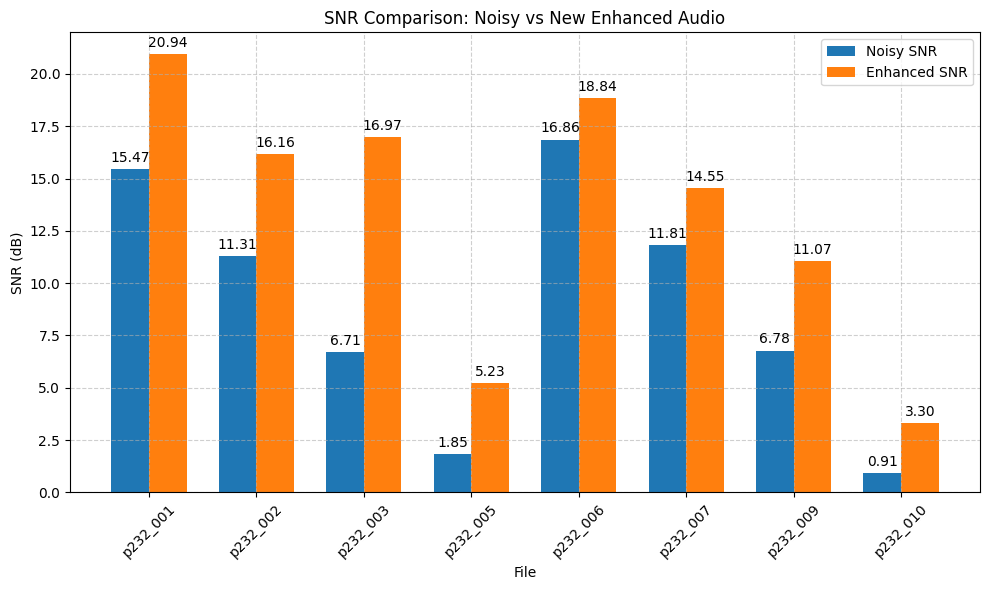


Average SNR Improvement: 4.42 dB


In [2]:
noisy_data = {
    'filename': [
        'p232_001', 'p232_002', 'p232_003', 'p232_005',
        'p232_006', 'p232_007', 'p232_009', 'p232_010'
    ],
    'noisy_snr': [
        15.47, 11.31, 6.71, 1.85, 16.86, 11.81, 6.78, 0.91
    ]
}


enhanced_data = {
    'filename': [
        'p232_001', 'p232_002', 'p232_003', 'p232_005',
        'p232_006', 'p232_007', 'p232_009', 'p232_010'
    ],
    'enhanced_snr': [
        20.94, 16.16, 16.97, 5.23, 18.84, 14.55, 11.07, 3.30
    ]
}


df_noisy = pd.DataFrame(noisy_data)
df_enhanced = pd.DataFrame(enhanced_data)
df_combined = pd.merge(df_noisy, df_enhanced, on='filename')
df_combined['snr_improvement'] = df_combined['enhanced_snr'] - df_combined['noisy_snr']
print(df_combined)


x = np.arange(len(df_combined))  # label locations
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, df_combined['noisy_snr'], width, label='Noisy SNR')
bars2 = ax.bar(x + width/2, df_combined['enhanced_snr'], width, label='Enhanced SNR')

ax.set_xlabel('File')
ax.set_ylabel('SNR (dB)')
ax.set_title('SNR Comparison: Noisy vs New Enhanced Audio')
ax.set_xticks(x)
ax.set_xticklabels(df_combined['filename'], rotation=45)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

avg_improvement = df_combined['snr_improvement'].mean()
print(f"\nAverage SNR Improvement: {avg_improvement:.2f} dB")
